
# Shock Tube (0D) Example in Cantera

This notebook shows how to run a single-zone shock tube simulation (constant-volume, adiabatic) using the (old version but isn't an issue) RMG-exported Cantera YAML. We reuse the duplicate-reaction fixer and species-name helper from the other tutorials, then set post-shock conditions, integrate in time, and compute an ignition delay marker.



## Key concepts
- **Post-shock state**: a shock tube test is modeled as a well-mixed, constant-volume, adiabatic reactor starting at the post-shock temperature and pressure.
- **Ignition delay**: often taken as the time of maximum temperature rise (peak dT/dt) or peak OH. Here we report the time of maximum dT/dt.
- **Energy on, constant volume**: we use `IdealGasReactor` with energy enabled (default) and fixed volume; no mass inflow or outflow.



## What you need
- Run from the `RMG-Py` repository root.
- Dependencies: `cantera`, `pyyaml`, `numpy`, `matplotlib`.
- We reuse the duplicate-reaction fixer (`fix_cantera`) so Cantera can load the RMG mechanism cleanly.


In [1]:
"""
t3 utils fix_cantera module
A module to automatically fix issues with RMG-generated Cantera files, mainly resolving mislabeled duplicate reactions.
"""
import os

from typing import List, Optional, Union

import shutil
import time
import traceback
import yaml
import cantera as ct

class InputError(Exception):
    """Raised when an input to the Cantera-fixing utilities is invalid."""
    pass

def globalize_paths(path: str, project_directory: str) -> str:
    """
    Convert a relative path into an absolute path based on project_directory.
    If path is already absolute, return it unchanged.
    """
    if os.path.isabs(path):
        return path
    return os.path.normpath(os.path.join(project_directory, path))


def read_yaml_file(path: str,
                   project_directory: Optional[str] = None,
                   ) -> Union[dict, list]:
    """
    Read a YAML file (usually an input / restart file, but also conformers file)
    and return the parameters as python variables.

    Args:
        path (str): The YAML file path to read.
        project_directory (str, optional): The current project directory to rebase upon.

    Returns: Union[dict, list]
        The content read from the file.
    """
    if project_directory is not None:
        path = globalize_paths(path, project_directory)
    if not isinstance(path, str):
        raise InputError(f'path must be a string, got {path} which is a {type(path)}')
    if not os.path.isfile(path):
        raise InputError(f'Could not find the YAML file {path}')
    with open(path, 'r') as f:
        content = yaml.load(stream=f, Loader=yaml.FullLoader)
    return content

def to_yaml(py_content: Union[list, dict]) -> str:
    """
    Convert a Python list or dictionary to a YAML string format.

    Args:
        py_content (list, dict): The Python content to save.

    Returns: str
        The corresponding YAML representation.
    """
    yaml.add_representer(str, string_representer)
    yaml_str = yaml.dump(data=py_content)
    return yaml_str


def string_representer(dumper, data):
    """
    Add a custom string representer to use block literals for multiline strings.
    """
    if len(data.splitlines()) > 1:
        return dumper.represent_scalar(tag='tag:yaml.org,2002:str', value=data, style='|')
    return dumper.represent_scalar(tag='tag:yaml.org,2002:str', value=data)

def save_yaml_file(path: str,
                   content: Union[list, dict],
                   ) -> None:
    """
    Save a YAML file (usually an input / restart file, but also conformers file).

    Args:
        path (str): The YAML file path to save.
        content (list, dict): The content to save.
    """
    if not isinstance(path, str):
        raise InputError(f'path must be a string, got {path} which is a {type(path)}')
    yaml_str = to_yaml(py_content=content)
    if '/' in path and os.path.dirname(path) and not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))
    with open(path, 'w') as f:
        f.write(yaml_str)


def get_traceback(model_path: str) -> Optional[str]:
    """
    Try loading the Cantera model and return the traceback if it fails.

    Args:
        model_path (str): The path to the cantera YAML model file.

    Returns:
        Optional[str]: The traceback if the model fails to load.
    """
    tb = None
    try:
        ct.Solution(model_path)
    except ct.CanteraError:
        tb = traceback.format_exc()
    return tb


def fix_cantera(model_path: str):
    """
    Fix a Cantera model that has incorrectly marked duplicate reactions.
    Creates a backup copy of the Cantera model and fixes the content of the original file in place.

    Args:
        model_path (str): The path to the cantera YAML model file.

    Returns:
        bool: Whether the model was fixed.
    """
    shutil.copyfile(model_path, model_path + '.bak')
    done, fixed = False, False
    counter = 0
    while not done and counter < 1000:
        counter += 1
        tb = get_traceback(model_path)
        if tb is None:
            done = True
            break
        else:
            if 'Undeclared duplicate reactions detected' in tb:
                fix_undeclared_duplicate_reactions(model_path, tb)
                fixed = True
            elif 'No duplicate found for declared duplicate reaction' in tb:
                fix_no_duplicate_found(model_path, tb)
                fixed = True
            else:
                print(f'Could not fix {model_path}:\n\n{tb}')
                break
        time.sleep(1)
    if fixed:
        print(f'Fixing Cantera model {model_path} (and creating a backup copy with a .bak extension).')
    else:
        os.remove(model_path + '.bak')
    return done


def fix_undeclared_duplicate_reactions(model_path: str, tb: str):
    """
    Fix a Cantera model that has undeclared duplicate reactions.

    Args:
        model_path (str): The path to the cantera YAML model file.
        tb (str): The traceback.
    """
    content = read_yaml_file(model_path)
    rxns = get_dup_rxn_indices(tb)
    print(f'Marking reactions {", ".join([str(r) for r in rxns])} as duplicate.')
    for i in rxns:
        content['reactions'][i - 1]['duplicate'] = True
    save_yaml_file(model_path, content)


def fix_no_duplicate_found(model_path: str, tb: str):
    """
    Fix a Cantera model that has a reaction marked as duplicate by mistake with no other duplicate reaction.

    Args:
        model_path (str): The path to the cantera YAML model file.
        tb (str): The traceback.
    """
    content = read_yaml_file(model_path)
    rxns = get_mistakenly_marked_dup_rxns(tb)
    for i in rxns:
        if 'duplicate' in content['reactions'][i].keys():
            print(f'Marking reaction {i} as non-duplicate.')
            del content['reactions'][i]['duplicate']
    save_yaml_file(model_path, content)


def get_dup_rxn_indices(tb: str) -> List[int]:
    """
    Get the duplicate reactions from the traceback.

    Args:
        tb (str): The traceback.

    Returns:
        List[int]: The reactions indices.
    """
    rxns = list()
    if tb is None:
        return rxns
    lines = tb.split('\n')
    read = False
    for line in lines:
        if 'Undeclared duplicate reactions detected:' in line:
            read = True
        if '|  Line |' in line:
            break
        if read and 'Reaction' in line:
            rxns.append(int(line.split()[1].split(':')[0]))
    return rxns


def get_mistakenly_marked_dup_rxns(tb: str) -> List[int]:
    """
    Get the duplicate reactions from the traceback.

    Args:
        tb (str): The traceback.

    Returns:
        List[int]: The reactions indices.
    """
    rxns = list()
    if tb is None:
        return rxns
    lines = tb.split('\n')
    for line in lines:
        if 'No duplicate found for declared duplicate reaction number' in line:
            rxns.append(int(line.split()[8]))
    return rxns


## Fix the RMG-generated Cantera file (optional)
If Cantera raises duplicate-reaction bookkeeping errors, the helper below will patch the YAML in place and keep a `.bak` copy. If the file loads cleanly, nothing is changed.


In [2]:

model_path = "dmf.cti"

# Only modifies the YAML if Cantera reports duplicate bookkeeping issues.
_ = fix_cantera(model_path)


/tmp/ipykernel_707510/3736317385.py:107: DeprecationWarning: XML_Node::build: 
The CTI and XML input file formats are deprecated and will be removed in
Cantera 3.0. Use 'cti2yaml.py' or 'ctml2yaml.py' to convert CTI or XML input
files to the YAML format. See https://cantera.org/tutorials/legacy2yaml.html
for more information.
  ct.Solution(model_path)



## Handle RMG species names
Species names include numeric identifiers (e.g., `NH3(1)`). The helper returns the full Cantera species name from a base label so you don't have to track the numbering manually.


In [3]:
def get_species(gas, name):
    for s in gas.species_names:
        if s == name:        # exact match (Ar, N2, He...)
            return s
        if s.startswith(name + "("):  # RMG-style match
            return s
    raise KeyError(f"Species {name} not found.")


# Setup and time integration

In this section, we create a 0-dimensional shcok-tube reactor, set it spost-shock state and integrate its chemistry forward in time.

- A shock tube can be modeled as a constant-volumen, adiabetic reactor that starts at the post-shock temperature, post-shick pressure, and mixture composition.
- The gas mixture is defined using the RMG mechanism file (chem_annotated.yml). RMG species often have names like `DMF(1)` or `OH(5)`, so we map simple labels (e.g. `DMF`) to the full Cantera species names.
- We then create an `IdealGasReactor`, which solves the coupled ODE system for temperature, pressure, and chemical composition inside a perfectly mixed reactor.
- The reactor is placed inside a ReactorNet, which advances the solution in time using Cantera's adaptive time-stepping integrator
- As the simulation progresses, we periodically store the full thermodynamic state (`T`, `P`, species mass/mol fractions) into a `SolutionArray` so we can analyse ignition behaviour later.

In [4]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import time

# Load mechanism
gas = ct.Solution(model_path)

# Data from literature
T_post = 1310.0  # K
P_post = 3.92 * 101325.0  # Pa

# Data mapping extraction from the model RMG generated
DMF_name = get_species(gas, "DMF")   # e.g. "DMF(1)"
O2_name  = get_species(gas, "O2")    # e.g. "O2(2)"
Ar_name = get_species(gas, "Ar")

# Initial composition (mole fractions) used in the RMG reactor input
composition = {
    DMF_name: 0.01,
    O2_name:  0.075,
    Ar_name:     0.915,
}

# Set initial state
gas.TPX = T_post, P_post, composition

# Small reference volume (no flow)
volume = 1.0e-5  # m^3

# Constant-volume, adiabatic reactor (shock-tube zone)
# Adding toa reactor net, the network is cantera's ODE system that inegrates species and energy equations in time
reactor = ct.IdealGasReactor(gas, energy="on", volume=volume)
sim = ct.ReactorNet([reactor])

# Store time history
history = ct.SolutionArray(gas, extra=["t"])

# Estimated ignition delay time window
# Integrate the system until a specified max time, storing snapshots of the reactor state at regular intervals.
max_time = 0.005  # seconds (5 ms) (from literature)
sample_every = 20

start = time.time()
t = 0.0
step_count = 0
while t < max_time:
    t = sim.step()
    step_count += 1
    if step_count % sample_every == 0:
        history.append(reactor.thermo.state, t=t)
end = time.time()

print(f"Ran {step_count} steps in {end - start:0.2f} s")


Ran 3028 steps in 0.14 s


# Ignition delay analysis (dT/dt vs OH peak)

Ignition delay (IDT) in a shock tube is usually defined using one of two signals.

1. Peak temperature rise - the time where $\frac{dT}{dt}$ reaches its maximum
2. Peak OH radical concentration - the time where $Y_{OH}$ or $X_{OH}$ reaches its maximum

Two different methods, so depends on your paper.

In [5]:
# --- Temperature-based IDT (dT/dt maximum) ---

T_trace = np.array(history.T)
Time = np.array(history.t)

dTdt = np.gradient(T_trace, Time, edge_order=2)
idx_T = np.argmax(dTdt)
idt_T = Time[idx_T]

if dTdt.max() < 1e3:
    print("No strong ignition detected (dT/dt is small).")

print(f"dT/dt-based IDT: {idt_T*1e3:.3f} ms")

# --- OH-based IDT (peak OH mass fraction) ---

OH_name = get_species(gas, "OH")              # e.g. "OH(5)"
i_OH = gas.species_index(OH_name)

Y_OH = history.Y[:, i_OH]
idx_OH = np.argmax(Y_OH)
idt_OH = Time[idx_OH]

# Mol fraction
X_OH = history.X[:, i_OH]

print(f"OH-peak-based IDT: {idt_OH*1e3:.3f} ms")


dT/dt-based IDT: 0.750 ms
OH-peak-based IDT: 0.753 ms


# Plots

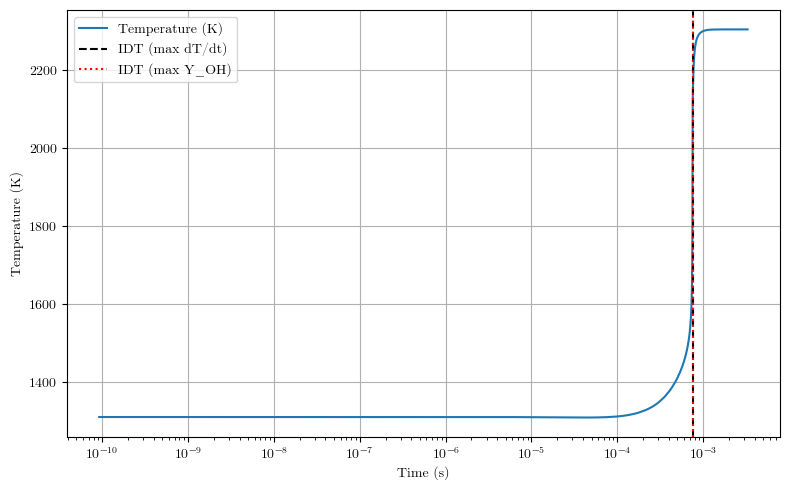

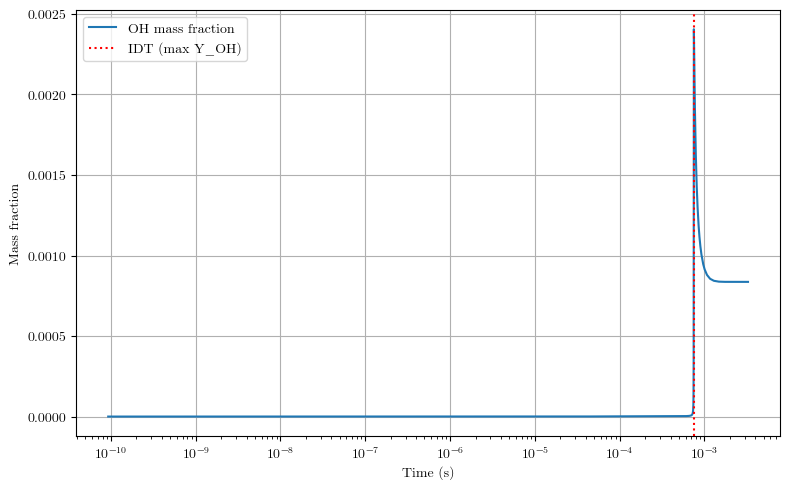

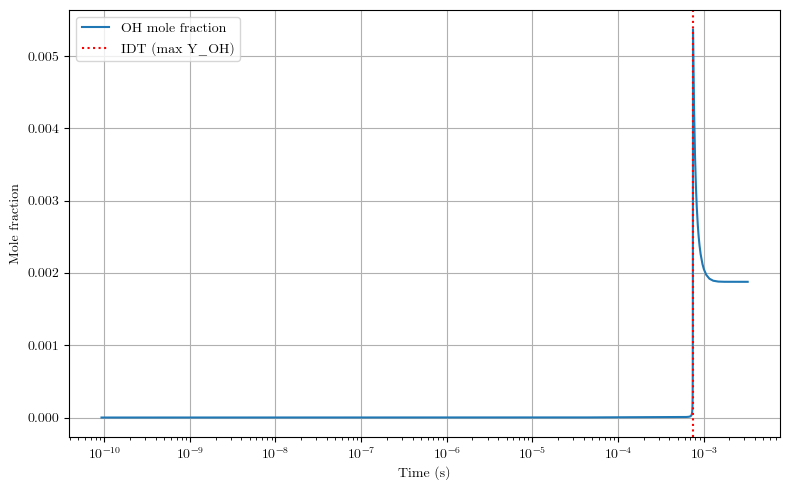

In [6]:
# Temperature vs time with both IDT markers
plt.figure(figsize=(8, 5))
plt.semilogx(Time, T_trace, label="Temperature (K)")
plt.axvline(idt_T, color="k", linestyle="--", label="IDT (max dT/dt)")
plt.axvline(idt_OH, color="r", linestyle=":", label="IDT (max Y_OH)")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (K)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# OH mass fraction vs time
plt.figure(figsize=(8, 5))
plt.semilogx(Time, Y_OH, label="OH mass fraction")
plt.axvline(idt_OH, color="r", linestyle=":", label="IDT (max Y_OH)")
plt.xlabel("Time (s)")
plt.ylabel("Mass fraction")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 5))
plt.semilogx(Time, X_OH, label="OH mole fraction")
plt.axvline(idt_OH, color="r", linestyle=":", label="IDT (max Y_OH)")  # IDT marker still valid
plt.xlabel("Time (s)")
plt.ylabel("Mole fraction")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()